In [71]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../util')
import helper
import helper_eval

# parses dictionary from column
import ast
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

**Read games**

In [72]:

n=20

def read_games(folder, n=n):

    #read games from every json file in folder materials/games_hard
    games = []
    for i in range(0,n):
            games = games +[pd.read_json(folder+str(i)+".json")]

    return pd.concat(games)


games_level_B = read_games("../study_code/materials/games_level_B/")
games_level_A = read_games("../study_code/materials/games_level_A/")
games_level_C = read_games("../study_code/materials/games_level_C/")
games_cal = read_games("../study_code/materials/games_level_B_cal/", n=60)



In [73]:
shape = (5,13)
shape_center = (3,7)
row= (shape[0]-shape_center[0])//2
col = (shape[1]-shape_center[1])//2
nr_center = 21

def is_red(name):
    return any(substring in name for substring in ["hearts","diamonds"])

def process(games):

    vec_is_red = np.vectorize(is_red)

    games["game"]= games["game"].apply(lambda x: vec_is_red(np.array(x)).astype(int))
    games["shown_prob"] = games["game"].apply(lambda x: x[row:row+shape_center[0],col:col+shape_center[1]].sum()/nr_center *100)
    games["true_prob"]=(games["nr_reds"]/games["nr_total"])*100

process(games_level_B)
process(games_level_C)
process(games_level_A)
process(games_cal)

**Read data**

*Game Responses*

In [74]:
df_responses = pd.read_csv("../study_data/group_B.csv")
df_responses_level_A = pd.read_csv("../study_data/group_A.csv")
df_responses_level_C = pd.read_csv("../study_data/group_C.csv")
df_responses_level_BP = pd.read_csv("../study_data/group_BP.csv")
df_responses_calibration = pd.read_csv("../study_data/group_B_calibration.csv")

*Separate attention tests*

In [75]:
df_attention = df_responses[df_responses['game_id']<0]
df_responses = df_responses[df_responses['game_id']>=0]

df_attention_level_A = df_responses_level_A[df_responses_level_A['game_id']<0]
df_responses_level_A = df_responses_level_A[df_responses_level_A['game_id']>=0]

df_attention_level_C = df_responses_level_C[df_responses_level_C['game_id']<0]
df_responses_level_C = df_responses_level_C[df_responses_level_C['game_id']>=0]

df_attention_level_BP = df_responses_level_BP[df_responses_level_BP['game_id']<0]
df_responses_level_BP = df_responses_level_BP[df_responses_level_BP['game_id']>=0]

df_attention_calibration = df_responses_calibration[df_responses_calibration['game_id']<0]
df_responses_calibration = df_responses_calibration[df_responses_calibration['game_id']>=0]

***Filter participants with 2 or more mistakes in attention test***

Mistake -> human_conf is more than one standard deviation from mean response for the attention test

In [76]:
def filter_by_std(df, mult=1, compare="lower"):

    lower = df["human_conf"].mean() - mult*df["human_conf"].std()
    upper = df["human_conf"].mean() + mult*df["human_conf"].std()
    # print(lower,upper)
    return df[(df["human_conf"]<lower) | (df["human_conf"]>upper)]

all_attention = pd.concat([df_attention,df_attention_level_A,df_attention_level_C,df_attention_level_BP])

df_failed_attention = pd.concat([filter_by_std(all_attention[all_attention["true_prob"]==0], compare="upper"),
                                 filter_by_std(all_attention[all_attention["true_prob"]==100]),
                                 filter_by_std(all_attention[all_attention["true_prob"]==60])]).groupby(["level_name","participant_id"])["game_id"].count().reset_index()
ids=df_failed_attention[df_failed_attention["game_id"]>1]["participant_id"]


*Number of participants that failed attention check per group*

In [77]:
# print number of participants that failed attention check per group
all_data = pd.concat([df_responses,df_responses_level_A,df_responses_level_C, df_responses_level_BP])
all_data[(all_data["participant_id"].isin(ids))].groupby(["level_name"])["participant_id"].nunique()

level_name
level_A     15
level_B     17
level_BP     9
level_C     20
Name: participant_id, dtype: int64

In [78]:

df_failed_attention_cal = pd.concat([filter_by_std(df_attention_calibration[df_attention_calibration["true_prob"]==0], compare="upper"),
                                 filter_by_std(df_attention_calibration[df_attention_calibration["true_prob"]==100]),
                                 filter_by_std(df_attention_calibration[df_attention_calibration["true_prob"]==60])]).groupby(["level_name","participant_id"])["game_id"].count().reset_index()
ids_cal=df_failed_attention_cal[df_failed_attention_cal["game_id"]>1]["participant_id"]

df_responses_calibration[(df_responses_calibration["participant_id"].isin(ids_cal))].groupby(["level_name"])["participant_id"].nunique()

level_name
level_B_cal    42
Name: participant_id, dtype: int64

*Filter out participants*

In [79]:
df_responses = df_responses[~df_responses["participant_id"].isin(ids)]
df_responses_level_A = df_responses_level_A[~df_responses_level_A["participant_id"].isin(ids)]
df_responses_level_C = df_responses_level_C[~df_responses_level_C["participant_id"].isin(ids)]
df_responses_level_BP = df_responses_level_BP[~df_responses_level_BP["participant_id"].isin(ids)]

df_responses_calibration = df_responses_calibration[~df_responses_calibration["participant_id"].isin(ids_cal)]

*Save filtered out ids to use in survey analysis*

In [80]:
ids.to_csv("data/filtered_ids.csv", index=False)
ids_cal.to_csv("data/filtered_ids_cal.csv", index=False)

**Discretize Human Confidence**

In [81]:
conf_levels = ["very low", "low", "high", "very high","very high"]

def add_dm_conf(data): 
    divider = 100/(len(conf_levels)-1)
    data["dm_conf"] = np.array([conf_levels[int(i)] for i in np.floor(data["human_conf"]/divider)])
    #set dm_conf to high if human_conf is 50 and initial_decision is Red
    data.loc[(data["human_conf"]==50) & (data["initial_decision"]=="Red"),"dm_conf"]= "high"
    #set dm_conf to low if human_conf is 50 and initial_decision is Black
    data.loc[(data["human_conf"]==50) & (data["initial_decision"]=="Black"),"dm_conf"]= "low"

add_dm_conf(df_responses)
add_dm_conf(df_responses_level_A)
add_dm_conf(df_responses_level_C)
add_dm_conf(df_responses_level_BP)
add_dm_conf(df_responses_calibration)


***Compute Expected Accuracy (Utility)***

In [82]:
def add_util(data):
    data['initial_utility'] = data.apply(lambda x: x["true_prob"] if x["initial_decision"]=="Red" else 100-x["true_prob"], axis=1)
    data['final_utility'] = data.apply(lambda x: x["true_prob"] if x["final_decision"]=="Red" else 100-x["true_prob"], axis=1)
    data['best_utility'] = data.apply(lambda x: x["true_prob"] if ("Red" if x["true_prob"]>=50 else "Black")=="Red" else 100-x["true_prob"], axis=1)
    if "AI_conf_pre" in data.columns:
        data['AI_utility'] = data.apply(lambda x: x["true_prob"] if ("Red" if x["AI_conf_pre"]>=50 else "Black")=="Red" else 100-x["true_prob"], axis=1)
    else:
        data['AI_utility'] = data.apply(lambda x: x["true_prob"] if ("Red" if x["AI_conf"]>=50 else "Black")=="Red" else 100-x["true_prob"], axis=1)

    data[["best_joint_decision", "best_monotone_decision","best_joint_utility", "best_monotone_utility"]]= helper_eval.compute_utility(data, center=False)

add_util(df_responses)
add_util(df_responses_level_A)
add_util(df_responses_level_C)
add_util(df_responses_level_BP)
add_util(df_responses_calibration)

Get best monotone policy successful:  True
Get best monotone policy successful:  True
Get best monotone policy successful:  True
Get best monotone policy successful:  True
Get best monotone policy successful:  True


In [83]:
def get_avg_utility(data):

    if "initial_utility" in data:
      return data[["initial_utility", "final_utility","best_joint_utility", "best_monotone_utility", "best_utility", "AI_utility"]].mean()

# create dataframe with average utility per participant
df_acc = pd.DataFrame({"level_B": get_avg_utility(df_responses),"level_BP": get_avg_utility(df_responses_level_BP), "cal": get_avg_utility(df_responses_calibration),"level_A": get_avg_utility(df_responses_level_A), "level_C":get_avg_utility(df_responses_level_C)})

# melt dataframe for plotting
df_acc = pd.melt(df_acc.reset_index(), id_vars="index", var_name="Level", value_name="Expected Accuracy")
df_acc = df_acc.rename(columns={"index":"Policy"})
df_acc["Policy"] = df_acc["Policy"].replace({"initial_utility":"Initial Guess", "dm_conf_utility":"DM Confidence", "final_utility":"Final Guess", "best_joint_utility":"Best Joint", "best_monotone_utility":"Best Monotone", "best_utility":"Best", "AI_utility":"AI"})
df_acc["Level"] = df_acc["Level"].replace({"level_B":"Level B", "level_A":"Level A", "level_C":"Level C", "level_BP":"Level BP", "cal":"Calibration"})
df_acc = df_acc[df_acc["Policy"].isin(["Initial Guess", "Final Guess", "Best Joint", "Best Monotone", "AI"])]
df_acc = df_acc[df_acc["Level"].isin(["Level B", "Level A", "Level C", "Level BP"])]


***Set up for Figures***

In [84]:
#setup seaborn context and style
sns.set_context("paper")
sns.set_theme(style="whitegrid")
helper.latexify(font_size=9, small_font_size=7)

ABCBP_palette = ["#9ce0b0","#b2c8f7","#f1b2ad" ,"#96edf1"]
ABC_palette = ["#9ce0b0","#b2c8f7","#f1b2ad"]
BBP_palette = ["#f1b2ad" ,"#96edf1"]

In [85]:
#setup matplotlib for plotting with latex and tikz 
#(needed for group symbols in plot labels)

#needed to plot on pdf
plt.rcParams.update({
"pgf.texsystem": "pdflatex",
"pgf.preamble": r"""
    \usepackage{amsmath}
    \usepackage{amssymb}
    \usepackage{tikz}
    \usepackage{makecell}
    \usepackage{xcolor,colortbl}
    \definecolor{redarrow}{HTML}{c55c41}
    \definecolor{bluearrow}{HTML}{4b869a}
    \definecolor{boxgray}{HTML}{808082}
    \definecolor{circlegray}{HTML}{606671}
    \usetikzlibrary{patterns}
    \newcommand{\stripedboxinline}[1]{%
                \tikz[baseline=(eq.base)]{
                    \node[inner sep=2pt] (eq) {$#1$};
                    \draw[pattern=north west lines, pattern color=gray!20] (eq.south west) rectangle (eq.north east);
                    \draw[gray] (eq.south west) rectangle (eq.north east);
                    \node[inner sep=2pt] (inside) {$#1$};
                        }%
                }
    \newcommand{\symbolBP}{\stripedboxinline{\color{boxgray}\textcolor{circlegray}{\bullet}\textcolor{redarrow}{\rightarrow} \textcolor{bluearrow}{\leftarrow}\textcolor{circlegray}{\bullet}}\,\textcolor{boxgray}{$\scriptstyle \text{R}$}\,}
    \newcommand{\symbolB}{$\color{boxgray}\textcolor{circlegray}{\bullet}\textcolor{redarrow}{\rightarrow} \textcolor{bluearrow}{\leftarrow}\textcolor{circlegray}{\bullet}\ $}
    \newcommand{\symbolA}{$\color{boxgray}\textcolor{bluearrow}{\leftarrow} \textcolor{circlegray}{\bullet}\,\textcolor{circlegray}{\bullet}\textcolor{redarrow}{\rightarrow}\ $}
    \newcommand{\symbolC}{$\color{boxgray} \textcolor{circlegray}{\bullet}\quad\textcolor{circlegray}{\bullet}\ $}
    """
})

#needed to plot on notebook
plt.rc('text', usetex = True)
plt.rc('text.latex', preamble=r"""
    \usepackage{tikz}
    \usepackage{xcolor,colortbl}
    \definecolor{redarrow}{HTML}{c55c41}
    %\definecolor{bluearrow}{HTML}{4b869a}
    \definecolor{bluearrow}{rgb}{0.0,0.0,1.0}
    \definecolor{boxgray}{HTML}{808082}
    \definecolor{circlegray}{HTML}{606671}
    \usetikzlibrary{patterns}
    \newcommand{\stripedboxinline}[1]{%
                \tikz[baseline=(eq.base)]{
                    \node[inner sep=2pt] (eq) {$#1$};
                    \draw[pattern=north west lines, pattern color=gray!20] (eq.south west) rectangle (eq.north east);
                    \draw[gray] (eq.south west) rectangle (eq.north east);
                    \node[inner sep=2pt] (inside) {$#1$};
                        }%
                }
    \newcommand{\symbolBP}{\stripedboxinline{\color{boxgray}\textcolor{circlegray}{\bullet}\textcolor{redarrow}{\rightarrow} \textcolor{bluearrow}{\leftarrow}\textcolor{circlegray}{\bullet}}\,\textcolor{boxgray}{$\scriptstyle R$}\,}
    \newcommand{\symbolB}{$\color{boxgray}\textcolor{circlegray}{\bullet}\textcolor{redarrow}{\rightarrow} \textcolor{bluearrow}{\leftarrow}\textcolor{circlegray}{\bullet}\ $}
    \newcommand{\symbolA}{$\color{boxgray}\color{bluearrow}{\leftarrow} \color{circlegray}{\bullet}\,\color{circlegray}{\bullet}\color{redarrow}{\rightarrow}\ $}
    \newcommand{\symbolC}{$\color{boxgray} \textcolor{circlegray}{\bullet}\quad\textcolor{circlegray}{\bullet}\ $}
    """)



plt.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Computer Modern'
# matplotlib.verbose.level = 'debug-annoying'

In [86]:
# Code for checking latex is on path, insert if not
# import os
# # os.environ['PATH'] = "/Library/TeX/texbin:" + os.environ['PATH']
# print("LaTeX path:", os.popen('which latex').read())
# print("Font path:", matplotlib.get_data_path())

***Figure 1 - Games per group***

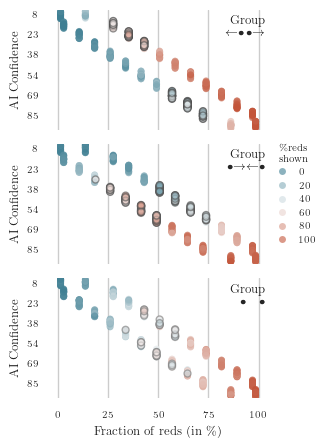

In [87]:

red_blue_palette = sns.diverging_palette(220, 20, as_cmap=True)


def plot_games(games, axes, legend=True):
   mask = (games["shown_prob"]<50) == (games["true_prob"]<50) 
   sns.stripplot(y="AI_conf", x="true_prob", orient="h", data=games, hue="shown_prob", ax=axes, hue_norm = (0,100), jitter=0.4, alpha=0.6, palette=red_blue_palette,legend=legend) 
   return sns.stripplot(y="AI_conf", x="true_prob", orient="h", data=games[~mask], edgecolor='auto',linewidth=1, hue="shown_prob", ax=axes, hue_norm = (0,100), jitter=0.4, alpha=0.6, palette=red_blue_palette,legend=False)

h,w =helper.get_fig_dim(242, 1.0)
fig, axes = plt.subplots(3,1, figsize=(h, w*2.2), sharex=True)

ax = plot_games(games_level_A, axes[0],legend=False)
ax.set_title(r'''Group \hspace{0.9em}
               \symbolA\hspace{0.7em}''',  loc="right", y=0.7)
ax.set_xlabel(r'Fraction of reds (in \%)')
ax.set_ylabel('AI Confidence')
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks(ax.get_yticks()[0::2])
sns.despine(ax=ax, top=True, right=True, bottom=True, left=True)


ax = plot_games(games_level_B, axes[1]) 
ax.legend( title=r"""\%reds
            shown""", loc='upper left', bbox_to_anchor=(1, 1.05),borderpad=0.2,frameon=False)
ax.set_title(r'''Group \hspace{0.9em}
               \symbolB\hspace{0.7em}''',  loc="right", y=0.7)
ax.set_xlabel(r'Fraction of reds (in \%)')
ax.set_ylabel('AI Confidence')
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks(ax.get_yticks()[0::2])
sns.despine(ax=ax, top=True, right=True, bottom=True, left=True)

ax = plot_games(games_level_C, axes[2],legend=False)

# Customize the x and y axis labels
ax.set_title(r'''Group \hspace{0.9em}
               \symbolC \hspace{1.3em}''',  loc="right", y=0.7)
ax.set_xlabel(r'Fraction of reds (in \%)')
ax.set_ylabel('AI Confidence')
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks(ax.get_yticks()[0::2])
sns.despine(ax=ax, top=True, right=True, bottom=True, left=True)

fig.tight_layout()
fig.savefig("./figures/games.pdf", bbox_inches='tight', dpi=300, backend='pgf')

plt.show()

*Horizontal Plot Alignment*

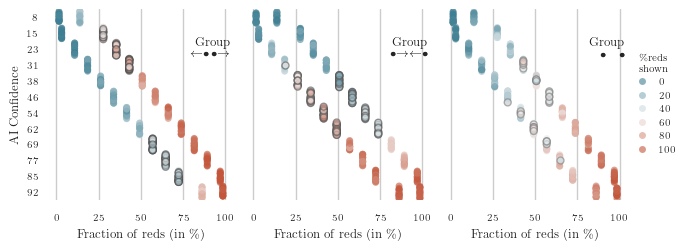

In [88]:

red_blue_palette = sns.diverging_palette(220, 20, as_cmap=True)


def plot_games(games, axes, legend=True):
   mask = (games["shown_prob"]<50) == (games["true_prob"]<50) 
   sns.stripplot(y="AI_conf", x="true_prob", orient="h", data=games, hue="shown_prob", ax=axes, hue_norm = (0,100), jitter=0.4, alpha=0.6, palette=red_blue_palette,legend=legend) 
   return sns.stripplot(y="AI_conf", x="true_prob", orient="h", data=games[~mask], edgecolor='auto',linewidth=1, hue="shown_prob", ax=axes, hue_norm = (0,100), jitter=0.4, alpha=0.6, palette=red_blue_palette,legend=False)

h,w =helper.get_fig_dim(502, 1.0)
fig, axes = plt.subplots(1,3, figsize=(h, 0.6*w), sharey=True)

ax = plot_games(games_level_A, axes[0],legend=False)
ax.set_title(r'''Group \hspace{0.5em}
               \symbolA\hspace{0.3em}''',  loc="right", y=0.7)
ax.set_xlabel(r'Fraction of reds (in \%)')
ax.set_ylabel('AI Confidence')
ax.set_xticks([0, 25, 50, 75, 100])
# ax.set_yticks(ax.get_yticks()[0::2])
sns.despine(ax=ax, top=True, right=True, bottom=True, left=True)


ax = plot_games(games_level_B, axes[1],legend=False) 
ax.set_title(r'''Group \hspace{0.5em}
               \symbolB\hspace{0.3em}''',  loc="right", y=0.7)
ax.set_xlabel(r'Fraction of reds (in \%)')
ax.set_ylabel('AI Confidence')
ax.set_xticks([0, 25, 50, 75, 100])
# ax.set_yticks(ax.get_yticks()[0::2])
sns.despine(ax=ax, top=True, right=True, bottom=True, left=True)

ax = plot_games(games_level_C, axes[2])
ax.legend( title=r"""\%reds
            shown""", loc='upper left', bbox_to_anchor=(1, 0.8),borderpad=0.2,frameon=False)

# Customize the x and y axis labels
ax.set_title(r'''Group \hspace{0.5em}
               \symbolC \hspace{0.9em}''',  loc="right", y=0.7)
ax.set_xlabel(r'Fraction of reds (in \%)')
# ax.set_ylabel('AI Confidence')
ax.set_xticks([0, 25, 50, 75, 100])
# ax.set_yticks(ax.get_yticks()[0::2])
sns.despine(ax=ax, top=True, right=True, bottom=True, left=True)

fig.tight_layout()
fig.savefig("./figures/games.pdf", bbox_inches='tight', dpi=300, backend='pgf')

plt.show()

***Figure 2 - Heatmap of decision probabilities***

In [89]:
#helper functions for plotting Figure 2

def prob_guess_red(x):
    if x.dtype == 'O': 
        return (x == "Red").mean()
    else:
        return x.mean()

def plot_heatmap(df, score, axes, cbar_ax=None):
    
    dm_conf_dict = {"very low": 0, "low":1 , "high":2, "very high":3}
    df["dm_conf_numeric"] = df.apply(lambda x: dm_conf_dict[x["dm_conf"]], axis=1)
    probmatrix = df[["dm_conf_numeric", "AI_conf", score]].groupby(["dm_conf_numeric", "AI_conf"]).agg(prob_guess_red).reset_index()
    probmatrix = probmatrix.pivot(index="AI_conf", columns="dm_conf_numeric", values=score)
    probmatrix.index = probmatrix.index.astype(int)
    countmatrix = df[["dm_conf_numeric", "AI_conf", score]].groupby(["dm_conf_numeric", "AI_conf"]).agg("count").reset_index()
    countmatrix = countmatrix.pivot(index="AI_conf", columns="dm_conf_numeric", values=score)>10

    if cbar_ax is None:
        sns.heatmap(probmatrix, ax=axes, vmin=0, vmax=1, cmap=red_blue_palette, mask=~countmatrix)
    if score=="initial_decision":
        probmatrix = df[["dm_conf_numeric", score]].groupby(["dm_conf_numeric"]).agg(prob_guess_red)
        probmatrix = probmatrix.T
        sns.heatmap(probmatrix, ax=axes, vmin=0, vmax=1, cmap=red_blue_palette, cbar_ax=cbar_ax)
    else:
        sns.heatmap(probmatrix, ax=axes, vmin=0, vmax=1, cmap=red_blue_palette, mask=~countmatrix,cbar_ax=cbar_ax)


    axes.set_xticklabels(["very\nlow", "low" , "high", "very\nhigh"], rotation=0)
    axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
    axes.set_xlabel("")
    axes.set_ylabel("")


*Figure 2*

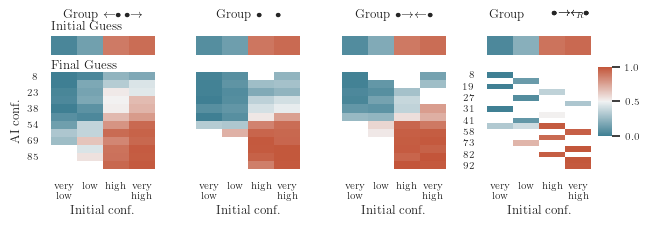

In [90]:

h,w =helper.get_fig_dim(504, 1.0)
# fig, axes = plt.subplots(3,4, figsize=(h, 1.5*w))
fig, axes = plt.subplots(2,4, sharex="col", figsize=(h, 0.4*w),gridspec_kw = {'wspace':0.4, 'hspace':0.3, 'height_ratios':[1, 5]})

cbar_ax = fig.add_axes([.91, .3, .02, .4])

axes[0][0].set_title(r"Group \symbolA", loc="center", y=1.5)
axes[0][0].set_title(f"Initial Guess", loc="left", y=0.85)
plot_heatmap(df_responses_level_A, "initial_decision", axes[0][0], cbar_ax)
axes[1][0].set_title(f"Final Guess", loc="left",y=0.95)
plot_heatmap(df_responses_level_A, "final_decision", axes[1][0], cbar_ax)

axes[0][1].set_title(r"Group \symbolC", loc="center", y=1.5)
plot_heatmap(df_responses_level_C, "initial_decision", axes[0][1], cbar_ax)
# axes[1][1].title.set_text("Level C")
plot_heatmap(df_responses_level_C, "final_decision", axes[1][1], cbar_ax)

axes[0][2].set_title(r"Group \symbolB", loc="center", y=1.5)
plot_heatmap(df_responses, "initial_decision", axes[0][2], cbar_ax)
# axes[1][2].title.set_text("Level B")
plot_heatmap(df_responses, "final_decision", axes[1][2], cbar_ax)


axes[0][3].set_title(r"Group \symbolBP", loc="center", y=1.5)
plot_heatmap(df_responses_level_BP, "initial_decision", axes[0][3], cbar_ax)
# axes[1][3].title.set_text("Level BP")
plot_heatmap(df_responses_level_BP, "final_decision", axes[1][3], cbar_ax)

axes[1][0].set_xlabel("Initial conf.")
axes[1][1].set_xlabel("Initial conf.")
axes[1][2].set_xlabel("Initial conf.")
axes[1][3].set_xlabel("Initial conf.")

axes[1][0].set_ylabel("AI conf.")
axes[1][0].set_yticklabels(axes[1][0].get_yticklabels(), rotation=0)


# axes[0][1].sharey(axes[0][0])
axes[0][0].set_yticklabels([])
axes[0][1].set_yticklabels([])
axes[0][2].set_yticklabels([])
axes[0][3].set_yticklabels([])
axes[1][1].set_yticklabels([])
axes[1][2].set_yticklabels([])


fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig("./figures/heatmap_decision.png", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()





*Figure S1 (Appendix)*

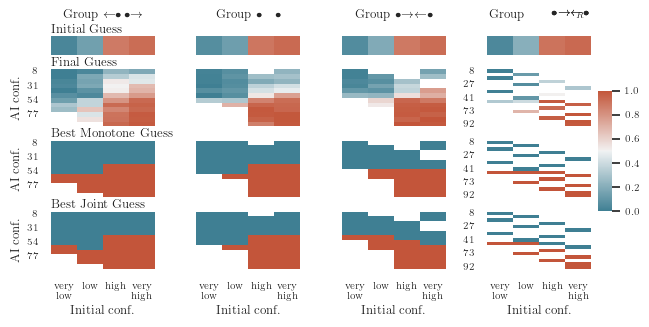

In [91]:

h,w =helper.get_fig_dim(504, 1.0)
fig, axes = plt.subplots(4,4, sharex="col", figsize=(h, 0.7*w),gridspec_kw = {'wspace':0.4, 'hspace':0.3, 'height_ratios':[1, 3, 3, 3]})

cbar_ax = fig.add_axes([.91, .3, .02, .4])

axes[0][0].set_title(r"Group \symbolA", loc="center", y=1.5)
axes[0][0].set_title(f"Initial Guess", loc="left", y=0.7)
plot_heatmap(df_responses_level_A, "initial_decision", axes[0][0], cbar_ax)
axes[1][0].set_title(f"Final Guess", loc="left",y=0.9)
plot_heatmap(df_responses_level_A, "final_decision", axes[1][0], cbar_ax)
axes[2][0].set_title(f"Best Monotone Guess", loc="left", y=0.9)
plot_heatmap(df_responses_level_A, "best_monotone_decision", axes[2][0], cbar_ax)
axes[3][0].set_title(f"Best Joint Guess", loc="left",y=0.9)
plot_heatmap(df_responses_level_A, "best_joint_decision", axes[3][0], cbar_ax)

axes[0][1].set_title(r"Group \symbolC", loc="center", y=1.5)
plot_heatmap(df_responses_level_C, "initial_decision", axes[0][1], cbar_ax)

plot_heatmap(df_responses_level_C, "final_decision", axes[1][1], cbar_ax)
plot_heatmap(df_responses_level_C, "best_monotone_decision", axes[2][1], cbar_ax)
plot_heatmap(df_responses_level_C, "best_joint_decision", axes[3][1], cbar_ax)

axes[0][2].set_title(r"Group \symbolB", loc="center", y=1.5)
plot_heatmap(df_responses, "initial_decision", axes[0][2], cbar_ax)
plot_heatmap(df_responses, "final_decision", axes[1][2], cbar_ax)
plot_heatmap(df_responses, "best_monotone_decision", axes[2][2], cbar_ax)
plot_heatmap(df_responses, "best_joint_decision", axes[3][2], cbar_ax)


axes[0][3].set_title(r"Group \symbolBP", loc="center", y=1.5)
plot_heatmap(df_responses_level_BP, "initial_decision", axes[0][3], cbar_ax)
plot_heatmap(df_responses_level_BP, "final_decision", axes[1][3], cbar_ax)
plot_heatmap(df_responses_level_BP, "best_monotone_decision", axes[2][3], cbar_ax)
plot_heatmap(df_responses_level_BP, "best_joint_decision", axes[3][3], cbar_ax)

axes[3][0].set_xlabel("Initial conf.")
axes[3][1].set_xlabel("Initial conf.")
axes[3][2].set_xlabel("Initial conf.")
axes[3][3].set_xlabel("Initial conf.")

axes[1][0].set_ylabel("AI conf.")
axes[1][0].set_yticklabels(axes[1][0].get_yticklabels(), rotation=0)

axes[2][0].set_ylabel("AI conf.")
axes[2][0].set_yticklabels(axes[1][0].get_yticklabels(), rotation=0)

axes[3][0].set_ylabel("AI conf.")
axes[3][0].set_yticklabels(axes[1][0].get_yticklabels(), rotation=0)

axes[0][0].set_yticklabels([])
axes[0][1].set_yticklabels([])
axes[0][2].set_yticklabels([])
axes[0][3].set_yticklabels([])
axes[1][1].set_yticklabels([])
axes[1][2].set_yticklabels([])
axes[2][1].set_yticklabels([])
axes[2][2].set_yticklabels([])
axes[3][1].set_yticklabels([])
axes[3][2].set_yticklabels([])

fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig("./figures/heatmap_decision_app.png", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()





***Table 1- Alignment Metrics***

In [92]:
df_alignment = pd.DataFrame([{"level_name": "Group B", "EAE": helper_eval.check_alignment(df_responses)[0],"MAE": helper_eval.check_alignment(df_responses)[1]}, {"level_name": "Group A", "EAE": helper_eval.check_alignment(df_responses_level_A)[0],"MAE": helper_eval.check_alignment(df_responses_level_A)[1]}, {"level_name": "Group C", "EAE": helper_eval.check_alignment(df_responses_level_C)[0],"MAE": helper_eval.check_alignment(df_responses_level_C)[1]}, {"level_name": "Group BP", "EAE": helper_eval.check_alignment(df_responses_level_BP)[0],"MAE": helper_eval.check_alignment(df_responses_level_BP)[1]}])#, {"level_name": "level_B_cal", "EAE": helper_eval.check_alignment(df_responses_calibration)[0],"MAE": helper_eval.check_alignment(df_responses_calibration)[1]}])
df_alignment

,level_name,EAE,MAE
0,Group B,0.00693,0.20
1,Group A,0.00065,0.10
2,Group C,0.00030,0.06
3,Group BP,0.00236,0.12


***Table S1 (Appendix) - ECE***

In [93]:
#ECE -- expected calibration error
print( "Group B: ")
helper_eval.check_calibration(df_responses)
print( "Group A: ")
helper_eval.check_calibration(df_responses_level_A)
print( "Group C: ")
helper_eval.check_calibration(df_responses_level_C)
print( "Group BP: ")
helper_eval.check_calibration(df_responses_level_BP)

Group B: 
0.03648190045248872
Group A: 
0.09032654600301661
Group C: 
0.05530185004868549
Group BP: 
0.033127641589180024


***Format data for Bayesian Analysis***

*Compare participants guesses to optimal guess*

In [94]:
df_stats = pd.concat([df_responses, df_responses_level_A, df_responses_level_C, df_responses_level_BP, df_responses_calibration]) 

#Compare participants guesses to optimal guess
df_stats["true_decision"] = df_stats.apply(lambda x:  "Red" if x["true_prob"]>50 else "Black", axis=1)
df_stats["initial_match"] = (df_stats["true_decision"] == df_stats["initial_decision"]).astype(int)
df_stats["final_match"] = (df_stats["true_decision"] == df_stats["final_decision"]).astype(int)

#Compute number of matchings per group, participant, game and intitial match result
df_stats_participant_match = df_stats[["participant_id","level_name","initial_match","game_batch","final_match"]].groupby(["participant_id","level_name","initial_match", "game_batch"]).agg(["sum","count"]).reset_index()
df_stats_participant_match.columns = [''.join(col).strip() for col in df_stats_participant_match.columns.values]

#Save dataframe for analysis in R
df_stats_participant_match.to_csv("./data/df_brms_match.csv", index=False)



***Figure 4c - Empirical matching rate of groups A,B and C stratified***

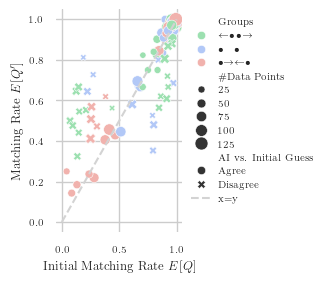

In [95]:
from scipy import stats

# Define a function to compute the confidence interval
def confidence_interval(data):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    ci = sem * stats.t.ppf((1 + 0.95) / 2., len(data)-1)  # 95% confidence interval
    return mean, ci

df_stats["round_prob"]=df_stats["true_prob"].round(0)
# Apply custom aggregation function
df_plot = df_stats[df_stats["level_name"].isin(["level_B", "level_A", "level_C"])][["AI_conf","round_prob", "true_prob", "dm_conf","level_name","initial_match", "final_match"]].groupby(["AI_conf", "dm_conf","level_name"]).agg(
    true_prob_mean=('true_prob', 'mean'),
    initial_match_mean=('initial_match', 'mean'),
    initial_match_std=('initial_match', 'std'),
    initial_match_count=('initial_match', 'count'),
    initial_match_ci=('initial_match', lambda x: confidence_interval(x)[1]),
    final_match_mean=('final_match', 'mean'),
    final_match_std=('final_match', 'std'),
    final_match_count=('final_match', 'count'),
    final_match_ci=('final_match', lambda x: confidence_interval(x)[1]),
).reset_index()

df_plot["AI vs. DM guess"] = df_plot[["AI_conf","dm_conf"]].apply(lambda row: "Agree" if (("Red" if row['AI_conf'] >50 else "Black") == ("Red" if row['dm_conf'] in ["high", "very high"] else "Black")) else "Disagree", axis=1)
df_plot.sort_values("AI vs. DM guess", inplace=True)


df_plot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_plot.columns.values]
h,w =helper.get_fig_dim(242, 1.0)
fig = plt.figure(figsize=(h, 1.4*w))
# #Arxiv format
# h,w =helper.get_fig_dim(502, 0.9)
# fig = plt.figure(figsize=(h, 0.6*w))
df_plot= df_plot[df_plot["initial_match_count"]>15]


# Create the scatter plot
ax = sns.scatterplot(data=df_plot, x="initial_match_mean", y="final_match_mean", hue="level_name", hue_order=["level_A","level_C", "level_B"], size="initial_match_count", style="AI vs. DM guess", palette=ABC_palette, marker="o", sizes=(20,100))

# Get colors from a palette
palette = sns.color_palette("husl", 3)  # Get 3 colors from the 'husl' palette
color_dict = dict(zip(["level_B", "level_A", "level_C"], palette))

x_vals = np.linspace(0, 1, 100)
plt.plot(x_vals, x_vals, '--', color='lightgray', label='x=y')

# Customize the legend
legend=ax.legend()

for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children():
        draw_area, text_area = hpack.get_children()
        for collection in text_area.get_children():
            if collection.get_text()=="level_name":
                text_area.set_text("Groups")
            if collection.get_text()=="level_A":
                text_area.set_text(r"\symbolA")
            if collection.get_text()=="level_B":
                text_area.set_text(r"\symbolB")
            if collection.get_text()=="level_C":
                text_area.set_text(r"\symbolC")
            if collection.get_text()=="level_BP":
                text_area.set_text(r"\symbolBP")
            if collection.get_text()=="initial_match_count":
                text_area.set_text(r"\#Data Points")
            if collection.get_text()=="AI vs. DM guess":
                text_area.set_text("AI vs. Initial Guess")


sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# Customize the x and y axis labels
ax.set_xlabel(r'Initial Matching Rate $E[Q]$')
ax.set_ylabel(r"Matching Rate $E[Q']$")
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
fig.tight_layout()
fig.savefig("./figures/consensus_ABC.pdf", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()

***Figure 5c - Empirical matching rate of groups B and BP stratified***

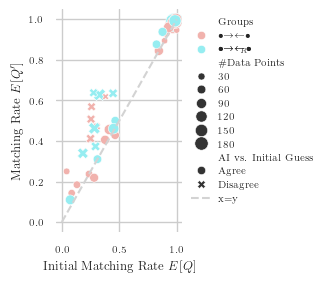

In [96]:
from scipy import stats
from matplotlib.gridspec import GridSpec


def confidence_interval(data):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    ci = sem * stats.t.ppf((1 + 0.95) / 2., len(data)-1)  # 95% confidence interval
    return mean, ci

# Apply custom aggregation function
df_plot = df_stats[df_stats["level_name"].isin(["level_B", "level_BP"])][["AI_conf", "true_prob", "dm_conf","level_name","initial_match", "final_match"]].groupby(["AI_conf","dm_conf","level_name"]).agg(
    true_prob_mean=('true_prob', 'mean'),
    initial_match_mean=('initial_match', 'mean'),
    initial_match_std=('initial_match', 'std'),
    initial_match_count=('initial_match', 'count'),
    initial_match_ci=('initial_match', lambda x: confidence_interval(x)[1]),
    final_match_mean=('final_match', 'mean'),
    final_match_std=('final_match', 'std'),
    final_match_count=('final_match', 'count'),
    final_match_ci=('final_match', lambda x: confidence_interval(x)[1])
).reset_index()

df_plot["AI vs. DM guess"] = df_plot[["AI_conf","dm_conf"]].apply(lambda row: "Agree" if (("Red" if row['AI_conf'] >50 else "Black") == ("Red" if row['dm_conf'] in ["high", "very high"] else "Black")) else "Disagree", axis=1)
df_plot.sort_values("AI vs. DM guess", inplace=True)


df_plot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_plot.columns.values]
h,w =helper.get_fig_dim(242, 1.0)
fig = plt.figure(figsize=(h, 1.4*w))
# #Arxiv format
# h,w =helper.get_fig_dim(502, 0.9)
# fig = plt.figure(figsize=(h, 0.6*w))

df_plot= df_plot[df_plot["initial_match_count"]>15]

# Create the scatter plot
ax = sns.scatterplot(data=df_plot, x="initial_match_mean", y="final_match_mean", hue="level_name",style="AI vs. DM guess", size='initial_match_count',marker="o", palette=BBP_palette, sizes=(20,100))

# Get colors from a palette
palette = sns.color_palette("husl", 2)  # Get 3 colors from the 'husl' palette
color_dict = dict(zip(["level_B", "level_BP"], palette))

# Add a dashed gray x=y line
x_vals = np.linspace(0, 1, 100)
plt.plot(x_vals, x_vals, '--', color='lightgray', label='x=y')

# Customize the legend
legend=ax.legend()

for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children():
        draw_area, text_area = hpack.get_children()
        for collection in text_area.get_children():
            if collection.get_text()=="level_name":
                text_area.set_text("Groups")
            if collection.get_text()=="level_A":
                text_area.set_text(r"\symbolA")
            if collection.get_text()=="level_B":
                text_area.set_text(r"\symbolB")
            if collection.get_text()=="level_C":
                text_area.set_text(r"\symbolC")
            if collection.get_text()=="level_BP":
                text_area.set_text(r"\symbolBP")
            if collection.get_text()=="initial_match_count":
                text_area.set_text(r"\#Data Points")
            if collection.get_text()=="AI vs. DM guess":
                text_area.set_text("AI vs. Initial Guess")


sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# Customize the x and y axis labels
ax.set_xlabel(r'Initial Matching Rate $E[Q]$')
ax.set_ylabel(r"Matching Rate $E[Q']$")
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
fig.tight_layout()
fig.savefig("./figures/consensus_BBP.pdf", bbox_inches='tight', dpi=300, backend='pgf')

plt.show()

***Figure S2a (Appendix) - Expected Accuracy averaged across participants and games for each group***

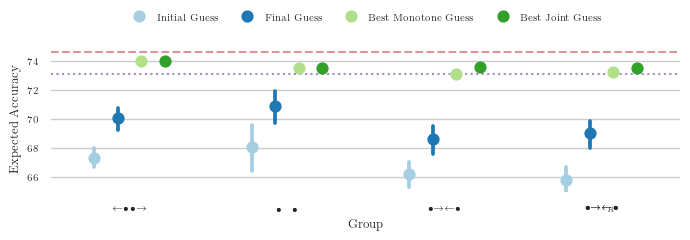

In [97]:
h,w =helper.get_fig_dim(504, 1.0)
fig = plt.figure(figsize=(h, 0.6*w))
pl=sns.color_palette("Paired", 10)
df_stats_participant = df_stats[["level_name","participant_id","initial_utility","final_utility","best_utility","AI_utility","best_joint_utility","best_monotone_utility"]].groupby(["level_name","participant_id"]).mean().reset_index()
df_plot = df_stats_participant.melt(id_vars=["participant_id","level_name"], value_vars=["final_utility","initial_utility","best_joint_utility","best_monotone_utility","best_utility"], var_name="Policy", value_name="Utility")

# add red dotted line indicating the mean best_utility
plt.axhline(y=df_stats_participant[df_stats_participant["level_name"]=="level_B"]["best_utility"].mean(), color='r', linestyle='--', alpha=0.6)
plt.axhline(y=df_stats_participant[df_stats_participant["level_name"]=="level_B"]["AI_utility"].mean(), color=pl[9], linestyle='dotted', alpha=0.6)

ax=sns.pointplot( y="Utility", x="level_name", order= ["level_A","level_C", "level_B", "level_BP"], data=df_plot, hue="Policy", hue_order=["initial_utility","final_utility","best_monotone_utility","best_joint_utility"], palette=pl[:4], dodge=0.45, linestyles="none")
legend=ax.legend()

for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children():
        draw_area, text_area = hpack.get_children()
        for collection in text_area.get_children():
            if collection.get_text()=="initial_utility":
                text_area.set_text("Initial Guess")
            if collection.get_text()=="final_utility":
                text_area.set_text(r"Final Guess")
            if collection.get_text()=="best_monotone_utility":
                text_area.set_text("Best Monotone Guess")
            if collection.get_text()=="best_joint_utility":
                text_area.set_text("Best Joint Guess")


sns.move_legend(ax, loc='center', bbox_to_anchor=(0.5, 1.2), frameon=False, ncol=4)
# Customize the x and y axis labels
ax.set_ylim(65, 75)
ax.set_xticklabels([r"\symbolA",r"\symbolC", r"\symbolB", r"\symbolBP"],)
ax.set_xlabel('Group')
ax.set_ylabel('Expected Accuracy')



sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
fig.tight_layout()
fig.savefig("./figures/utility_pointplot.pdf", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()

***Figure S2 b (Appendix) - Expected Accuracy of individual participants averaged across games for each group***

*Initial and Final Guess*

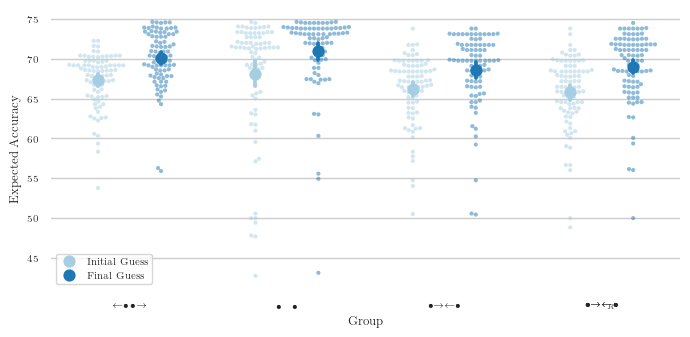

In [98]:
h,w =helper.get_fig_dim(504, 1.0)
fig = plt.figure(figsize=(h, 0.8*w))
pl=sns.color_palette("Paired", 10)
df_plot = df_stats_participant.melt(id_vars=["participant_id","level_name"], value_vars=["initial_utility","final_utility"], var_name="Policy", value_name="Expected Accuracy")
sns.pointplot(y="Expected Accuracy", x="level_name",data=df_plot,order= ["level_A","level_C", "level_B", "level_BP"], hue="Policy", hue_order=["initial_utility","final_utility"], palette=pl[:2], dodge=0.4, linestyles="none")
ax= sns.swarmplot(alpha=0.5,y="Expected Accuracy", x="level_name",data=df_plot,order= ["level_A","level_C", "level_B", "level_BP"], hue="Policy",hue_order=["initial_utility","final_utility"], palette=pl[:2], size=3, dodge=True, legend=False)

legend=ax.legend()
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children():
        draw_area, text_area = hpack.get_children()
        for collection in text_area.get_children():
            if collection.get_text()=="initial_utility":
                text_area.set_text("Initial Guess")
            if collection.get_text()=="final_utility":
                text_area.set_text(r"Final Guess")
            if collection.get_text()=="best_monotone_utility":
                text_area.set_text("Best Monotone Policy")
            if collection.get_text()=="best_joint_utility":
                text_area.set_text("Best Joint Policy")

ax.set_xticklabels([r"\symbolA",r"\symbolC", r"\symbolB", r"\symbolBP"],)
ax.set_xlabel('Group')
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)

fig.tight_layout()
fig.savefig("./figures/utility_swarmplot.pdf", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()

***Figure S2 c (Appendix) - Expected Accuracy of individual participants averaged across games for each group***

*Best Monotone and Best Joint Guess*

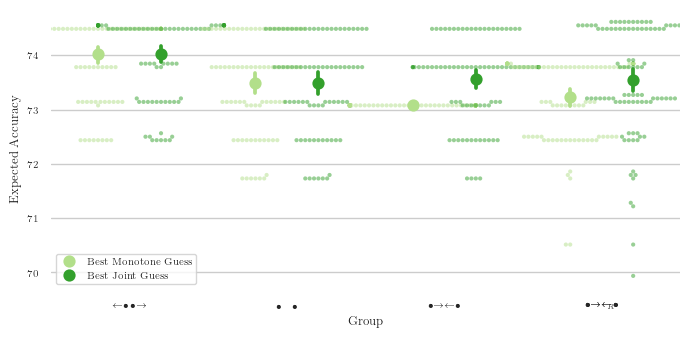

In [99]:
h,w =helper.get_fig_dim(504, 1.0)
fig = plt.figure(figsize=(h, 0.8*w))
pl=sns.color_palette("Paired", 10)
df_plot = df_stats_participant.melt(id_vars=["participant_id","level_name"], value_vars=["best_joint_utility","best_monotone_utility"], var_name="Policy", value_name="Expected Accuracy")
sns.pointplot(y="Expected Accuracy", x="level_name",data=df_plot,order= ["level_A","level_C", "level_B", "level_BP"], hue="Policy", hue_order=["best_monotone_utility","best_joint_utility"], palette=pl[2:4], dodge=0.4, linestyles="none")
ax= sns.swarmplot(alpha=0.5,y="Expected Accuracy", x="level_name",data=df_plot,order= ["level_A","level_C", "level_B", "level_BP"], hue="Policy",hue_order=["best_monotone_utility","best_joint_utility"], palette=pl[2:4], size=3, dodge=True, legend=False)

legend=ax.legend()
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children():
        draw_area, text_area = hpack.get_children()
        for collection in text_area.get_children():
            if collection.get_text()=="initial_utility":
                text_area.set_text("Initial Guess")
            if collection.get_text()=="final_utility":
                text_area.set_text(r"Final Guess")
            if collection.get_text()=="best_monotone_utility":
                text_area.set_text("Best Monotone Guess")
            if collection.get_text()=="best_joint_utility":
                text_area.set_text("Best Joint Guess")

ax.set_xticklabels([r"\symbolA",r"\symbolC", r"\symbolB", r"\symbolBP"],)
ax.set_xlabel('Group')

sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
fig.tight_layout()
fig.savefig("./figures/utility_swarmplot2.pdf", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()

***Figure S4 (Appendix) - Histogram of the difference between reported initial confidence and percentage of reds shown to participants for each group***

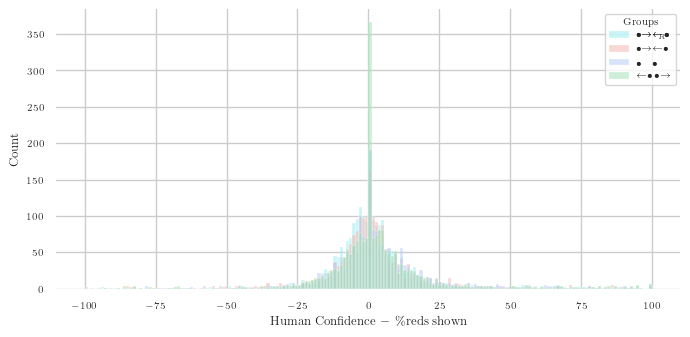

In [100]:
h,w =helper.get_fig_dim(504, 1.0)
fig, ax = plt.subplots(1,1,figsize=(h, 0.8*w))

df_plot = df_stats[["level_name","initial_decision", "human_conf", "nr_reds_shown"]]
df_plot["prob_reds_shown"] = df_plot["nr_reds_shown"]/21.0 *100
df_plot["reds_shown_decision"] = df_plot["prob_reds_shown"].apply(lambda x: "Red" if x>50 else "Black")

df_plot["diff"] = df_plot["human_conf"]-df_plot["prob_reds_shown"]

sns.histplot(x="diff", data=df_plot,hue="level_name", hue_order=["level_A","level_C","level_B","level_BP"], palette=ABCBP_palette, legend=True, ax=ax)# y="level_name",

# Customize the legend
custom_labels = [r"\symbolBP",r"\symbolB",r"\symbolC",r"\symbolA"]
plt.legend(title='Groups', loc='upper right', labels=custom_labels)

ax.set_xlabel(r"Human Confidence $-$ \%reds shown")

sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
fig.tight_layout()
fig.savefig("./figures/human_conf_diff_histplot.pdf", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()

## Figures for Calibration Data

***Figure S3a (Appendix) - Heatmap of decision probabilities***

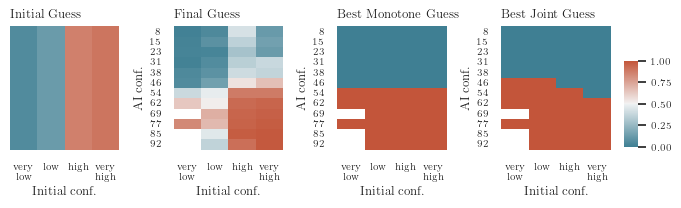

In [101]:
h,w =helper.get_fig_dim(504, 1.0)
fig, axes = plt.subplots(1,4, figsize=(h, 0.5*w))

cbar_ax = fig.add_axes([.9, .3, .02, .4])

axes[0].set_title(f"Initial Guess", loc="left", y=1.0)
plot_heatmap(df_responses_calibration, "initial_decision", axes[0], cbar_ax)
axes[1].set_title(f"Final Guess", loc="left",y=1.0)
plot_heatmap(df_responses_calibration, "final_decision", axes[1], cbar_ax)
axes[2].set_title(f"Best Monotone Guess", loc="left", y=1.0)
plot_heatmap(df_responses_calibration, "best_monotone_decision", axes[2], cbar_ax)
axes[3].set_title(f"Best Joint Guess", loc="left",y=1.0)
plot_heatmap(df_responses_calibration, "best_joint_decision", axes[3], cbar_ax)


axes[0].set_xlabel("Initial conf.")
axes[1].set_xlabel("Initial conf.")
axes[2].set_xlabel("Initial conf.")
axes[3].set_xlabel("Initial conf.")

axes[1].set_ylabel("AI conf.")
axes[2].set_ylabel("AI conf.")
axes[3].set_ylabel("AI conf.")
axes[0].set_yticklabels([])

fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig("./figures/heatmap_decision_cal.png", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()


***Figure S3b (Appendix) - Expected accuracy of each individual participant averaged across games for each guess type***

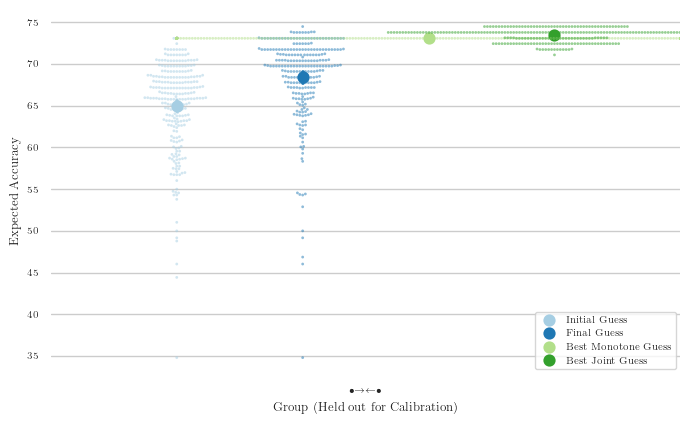

In [102]:
h,w =helper.get_fig_dim(504, 1.0)
fig = plt.figure(figsize=(h, w))
pl=sns.color_palette("Paired", 10)
df_plot = df_stats_participant.melt(id_vars=["participant_id","level_name"], value_vars=["initial_utility","final_utility","best_monotone_utility","best_joint_utility"], var_name="Policy", value_name="Expected Accuracy")
sns.pointplot(y="Expected Accuracy", x="level_name",data=df_plot,order= ["level_B_cal"], hue="Policy", hue_order=["initial_utility","final_utility","best_monotone_utility","best_joint_utility"], palette=pl[:4], dodge=0.6, linestyles="none")
ax= sns.swarmplot(alpha=0.5,y="Expected Accuracy", x="level_name",data=df_plot,order= ["level_B_cal"], hue="Policy",hue_order=["initial_utility","final_utility","best_monotone_utility","best_joint_utility"], palette=pl[:4], size=2, dodge=0.9, legend=False)

legend=ax.legend()
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children():
        draw_area, text_area = hpack.get_children()
        for collection in text_area.get_children():
            if collection.get_text()=="initial_utility":
                text_area.set_text("Initial Guess")
            if collection.get_text()=="final_utility":
                text_area.set_text(r"Final Guess")
            if collection.get_text()=="best_monotone_utility":
                text_area.set_text("Best Monotone Guess")
            if collection.get_text()=="best_joint_utility":
                text_area.set_text("Best Joint Guess")

ax.set_xticklabels([ r"\symbolB"],)
ax.set_xlabel('Group (Held out for Calibration)')

sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
fig.tight_layout()
fig.savefig("./figures/utility_swarmplot_cal.pdf", bbox_inches='tight', dpi=300, backend='pgf')
plt.show()